# Telecom Churn Prediction Notebook

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [127]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [128]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data/.DS_Store
Data/test.csv
Data/sample.csv
Data/train.csv
Data/data_dictionary.csv


In [129]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("Data/train.csv")
unseen = pd.read_csv("Data/test.csv")
sample = pd.read_csv("Data/sample.csv")
data_dict = pd.read_csv("Data/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [130]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [131]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


##### CLeaning the data , filling up the missing values and selecting required columns

In [132]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+inc.+mou',i)]

offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
onnetwork_minutes = [i for i in list(data.columns) if re.search('onnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
fb_sites_user = [i for i in list(data.columns) if re.search('fb',i)]
night_pack_user = [i for i in list(data.columns) if re.search('night',i)]
sachet_user_3g = [i for i in list(data.columns) if re.search('sachet.+3g',i)]
sachet_user_2g = [i for i in list(data.columns) if re.search('sachet.+2g',i)]
date_of_last_rech_data = [i for i in list(data.columns) if re.search('date.+of.+last.+rech.+data',i)]
last_day_rch_amt = [i for i in list(data.columns) if re.search('last.+day.+rch.+amt',i)]


std_og_mou = [i for i in list(data.columns) if re.search('std.+og.+mou',i)]
loc_og_mou = [i for i in list(data.columns) if re.search('loc.+og.+mou',i)]
isd_og_mou = [i for i in list(data.columns) if re.search('isd.+og.+mou',i)]
spl_og_mou = [i for i in list(data.columns) if re.search('spl.+og.+mou',i)]
roam_og_mou = [i for i in list(data.columns) if re.search('roam.+og.+mou',i)]

std_inc_mou = [i for i in list(data.columns) if re.search('std.+inc.+mou',i)]
loc_inc_mou = [i for i in list(data.columns) if re.search('loc.+inc.+mou',i)]
isd_inc_mou = [i for i in list(data.columns) if re.search('isd.+inc.+mou',i)]
spl_inc_mou = [i for i in list(data.columns) if re.search('spl.+inc.+mou',i)]
roam_inc_mou = [i for i in list(data.columns) if re.search('roam.+inc.+mou',i)]
 


#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes,
             *onnetwork_minutes,
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             *fb_sites_user,
             *night_pack_user,
             *sachet_user_3g,
             *sachet_user_2g,
             *date_of_last_rech_data,
             *last_day_rch_amt,
             *std_og_mou,
             *loc_og_mou,
             *isd_og_mou,
             *spl_og_mou,
             *roam_og_mou,
             *std_inc_mou,
             *loc_inc_mou,
             *isd_inc_mou,
             *spl_inc_mou,
             *roam_inc_mou,
             'churn_probability']

data = data[variables].set_index('id')

Let's look at each variable's datatype:

In [133]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,0.0,0.0,0.0,8.20,0.63,0.00,0.00,0.0,0.00,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.00,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.00,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,1.63,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,0.0,0.0,0.0,0.00,17.00,0.00,15.73,0.0,0.00,0


Let's look at each variable's datatype:

In [134]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 86 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   circle_id                 69999 non-null  int64  
 1   total_rech_amt_6          69999 non-null  int64  
 2   total_rech_amt_7          69999 non-null  int64  
 3   total_rech_amt_8          69999 non-null  int64  
 4   total_og_mou_6            69999 non-null  float64
 5   total_og_mou_7            69999 non-null  float64
 6   total_og_mou_8            69999 non-null  float64
 7   offnet_mou_6              67231 non-null  float64
 8   offnet_mou_7              67312 non-null  float64
 9   offnet_mou_8              66296 non-null  float64
 10  onnet_mou_6               67231 non-null  float64
 11  onnet_mou_7               67312 non-null  float64
 12  onnet_mou_8               66296 non-null  float64
 13  arpu_3g_6                 17568 non-null  float64
 14  arpu_3

Let's also summarize the features using the df.describe method:

In [135]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,0.845763,0.811100,0.841648,3.958619,4.976783,5.045027,14.186457,9.842191,9.771783,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,29.747486,29.220073,29.563367,15.854529,22.229842,17.708507,73.469261,58.511894,64.618388,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,0.000000,0.000000,0.000000,2.400000,3.660000,4.002500,0.000000,0.000000,0.000000,0.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [136]:
data['circle_id'].unique()

array([109])

In [137]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 84), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 84), (14000, 84), (55999,), (14000,))

In [139]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,onnet_mou_6,...,loc_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
id,,,,,,,,,,,,,,,,,,,,,
2733,765,174,524,1901.96,1308.21,370.33,1046.21,782.44,232.79,855.74,...,286.06,0.0,0.0,0.51,27.56,2.33,7.60,0.0,0.00,96.08
52712,210,160,270,109.86,152.44,94.79,99.99,143.23,96.96,9.14,...,33.64,0.0,0.0,0.00,0.00,0.00,16.01,0.0,0.00,9.04
14530,760,270,0,593.59,166.94,0.00,568.96,150.09,NaN,24.63,...,NaN,0.0,0.0,NaN,0.03,0.00,NaN,0.0,8.88,NaN
40450,0,382,302,64.26,55.03,58.51,50.19,48.96,47.61,13.13,...,54.71,0.0,0.0,0.00,0.93,0.00,3.80,0.0,0.00,0.00
39249,500,0,0,257.74,153.71,129.09,81.63,58.99,64.91,174.33,...,122.51,0.0,0.0,0.00,1.49,4.43,0.00,0.0,0.00,0.00


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

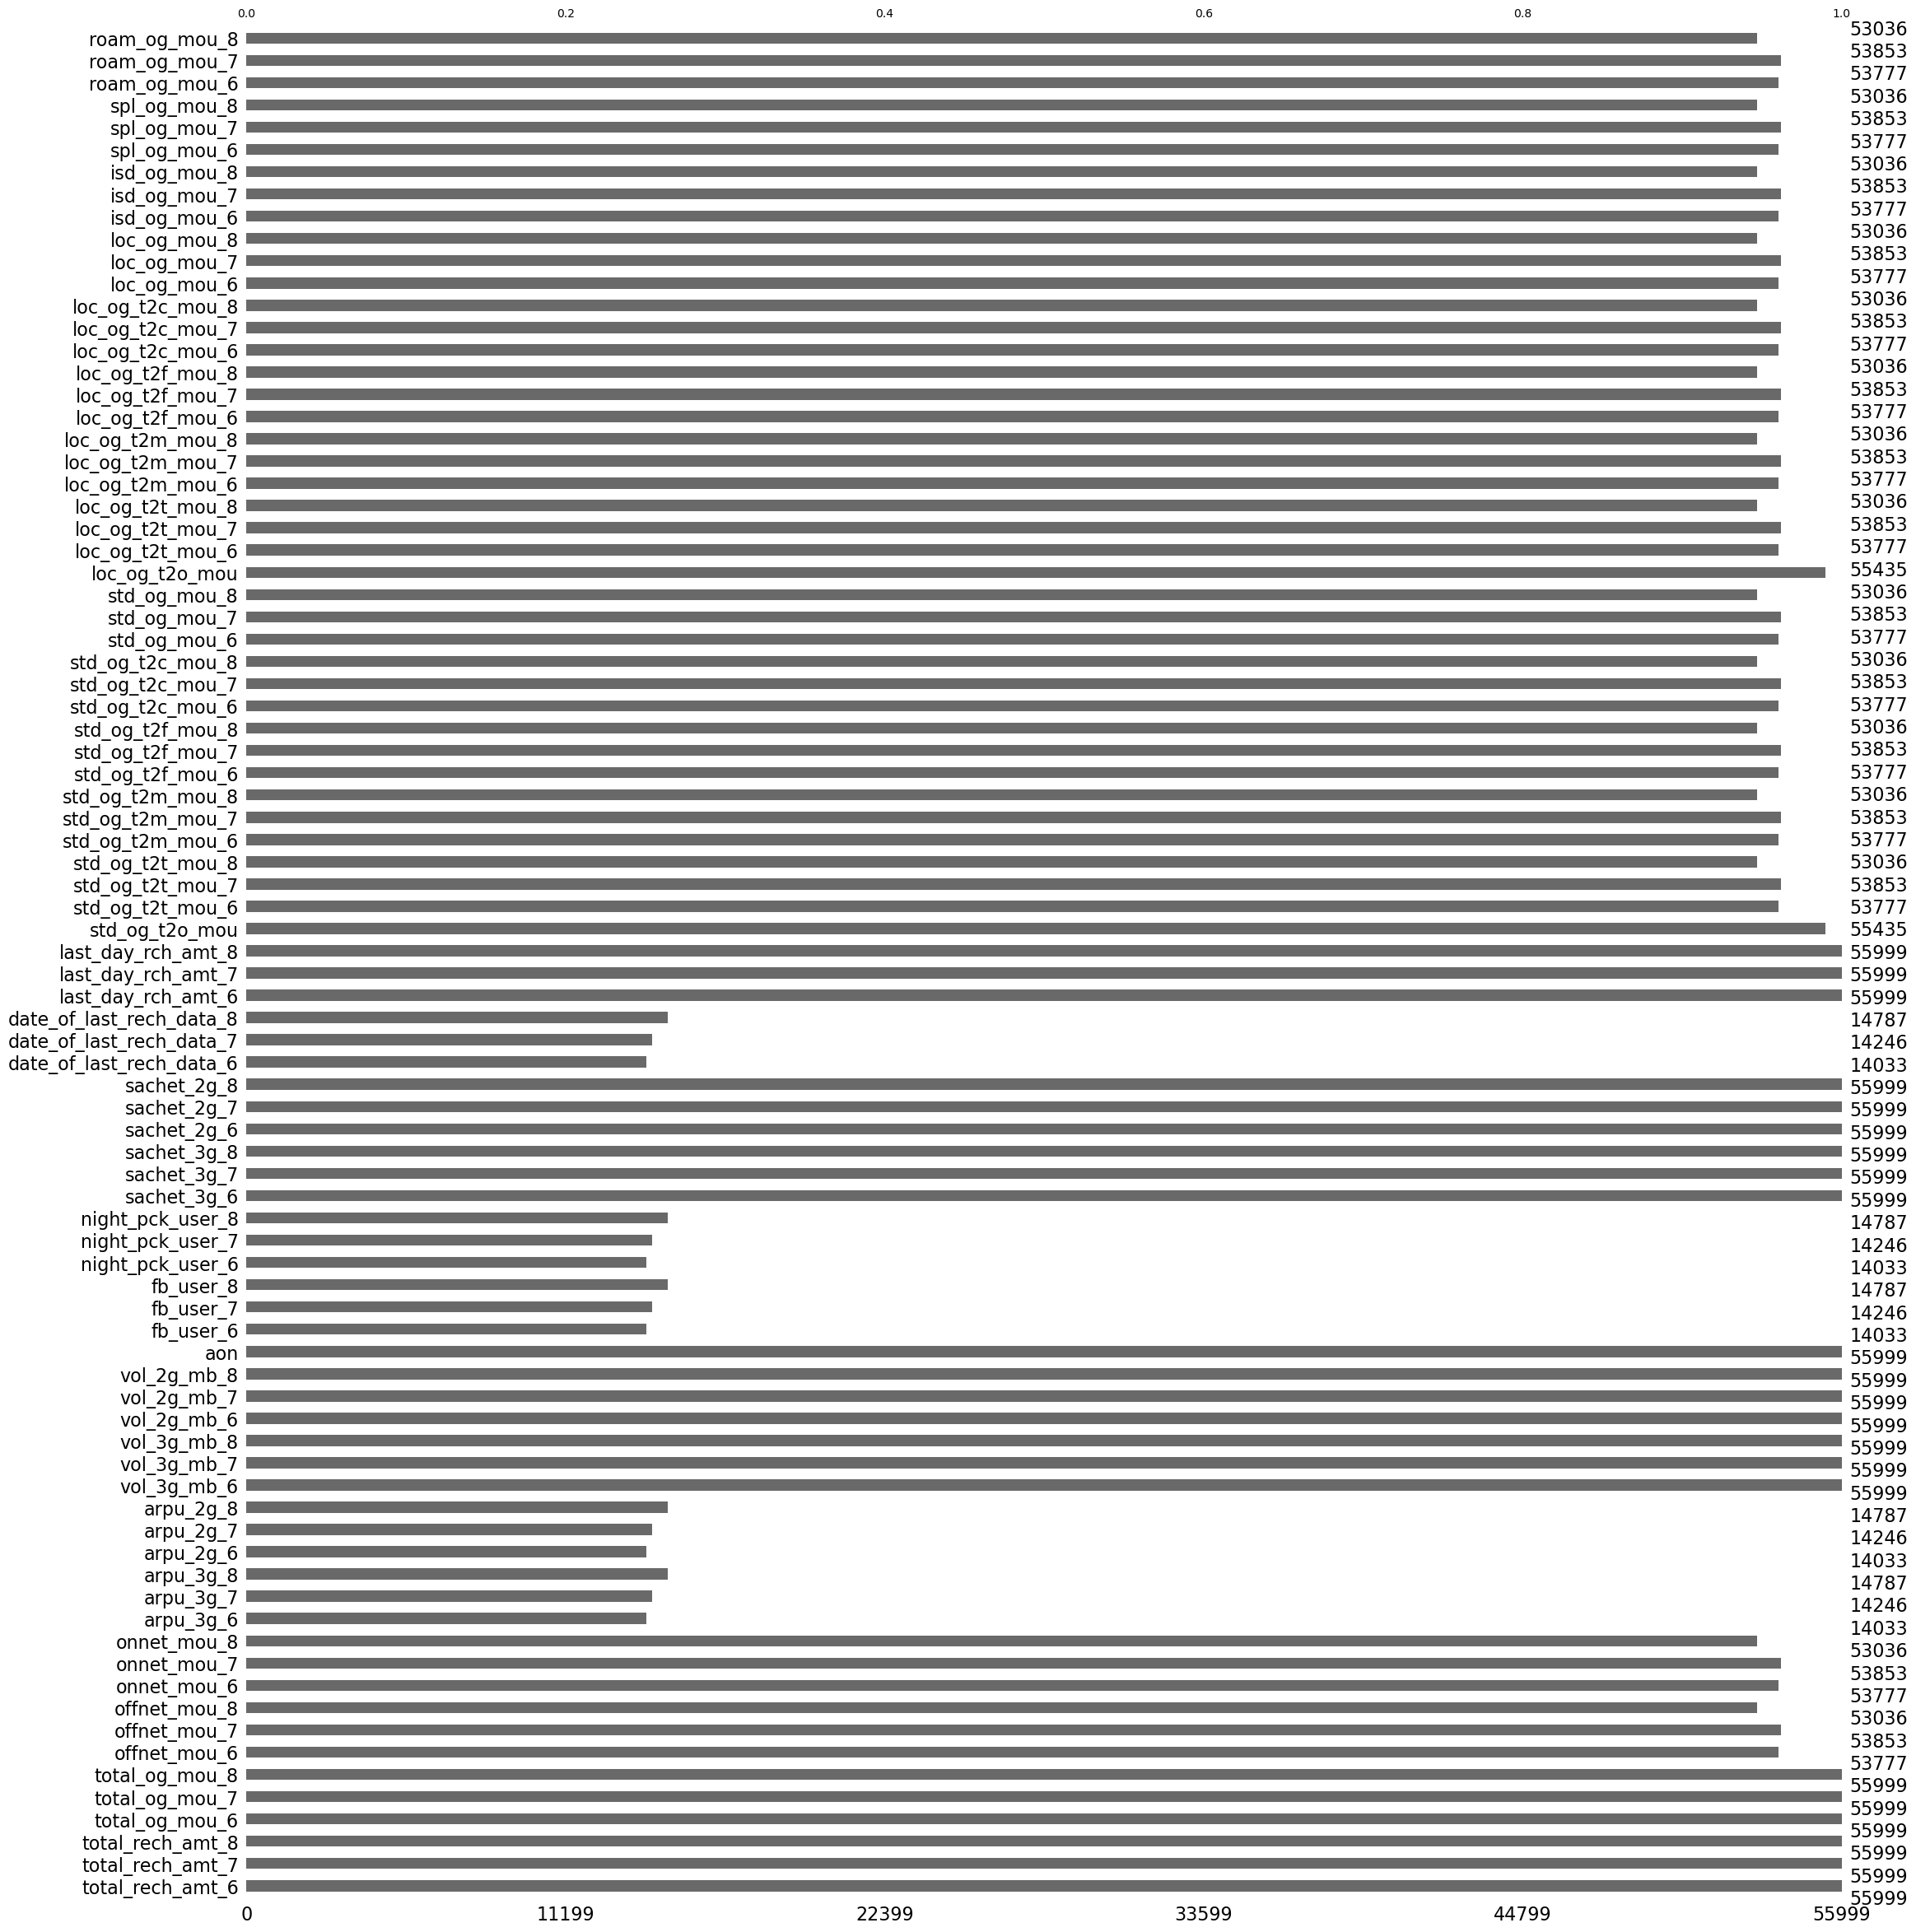

In [140]:
msno.bar(X_train)

<Axes: >

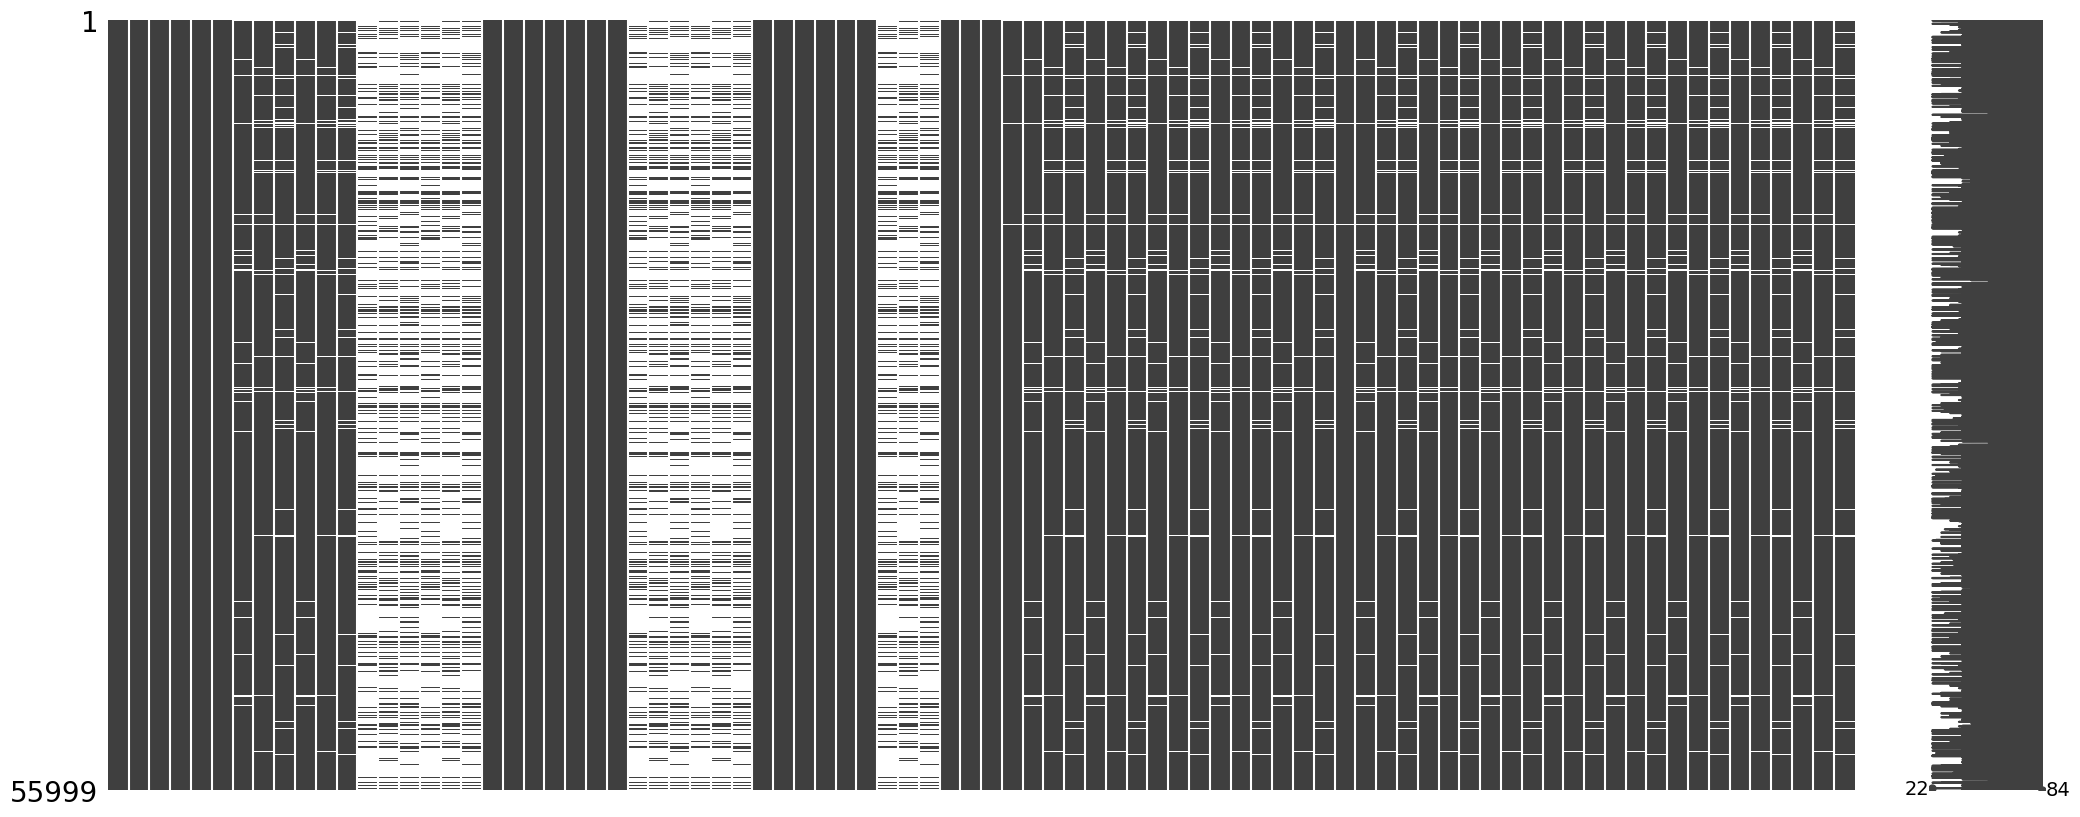

In [141]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [142]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6    0.000000
total_rech_amt_7    0.000000
total_rech_amt_8    0.000000
total_og_mou_6      0.000000
total_og_mou_7      0.000000
                      ...   
spl_og_mou_7        3.832211
spl_og_mou_8        5.291166
roam_og_mou_6       3.967928
roam_og_mou_7       3.832211
roam_og_mou_8       5.291166
Length: 84, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [143]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8',
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'sachet_2g_6', 'sachet_2g_7',
       'sachet_2g_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'std_og_t2o_mou', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'loc_og_t2o_mou', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m

In [144]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 69)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [145]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'std_og_t2o_mou', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'loc_og_t2o_mou', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8'],
      dtype='object')

In [146]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

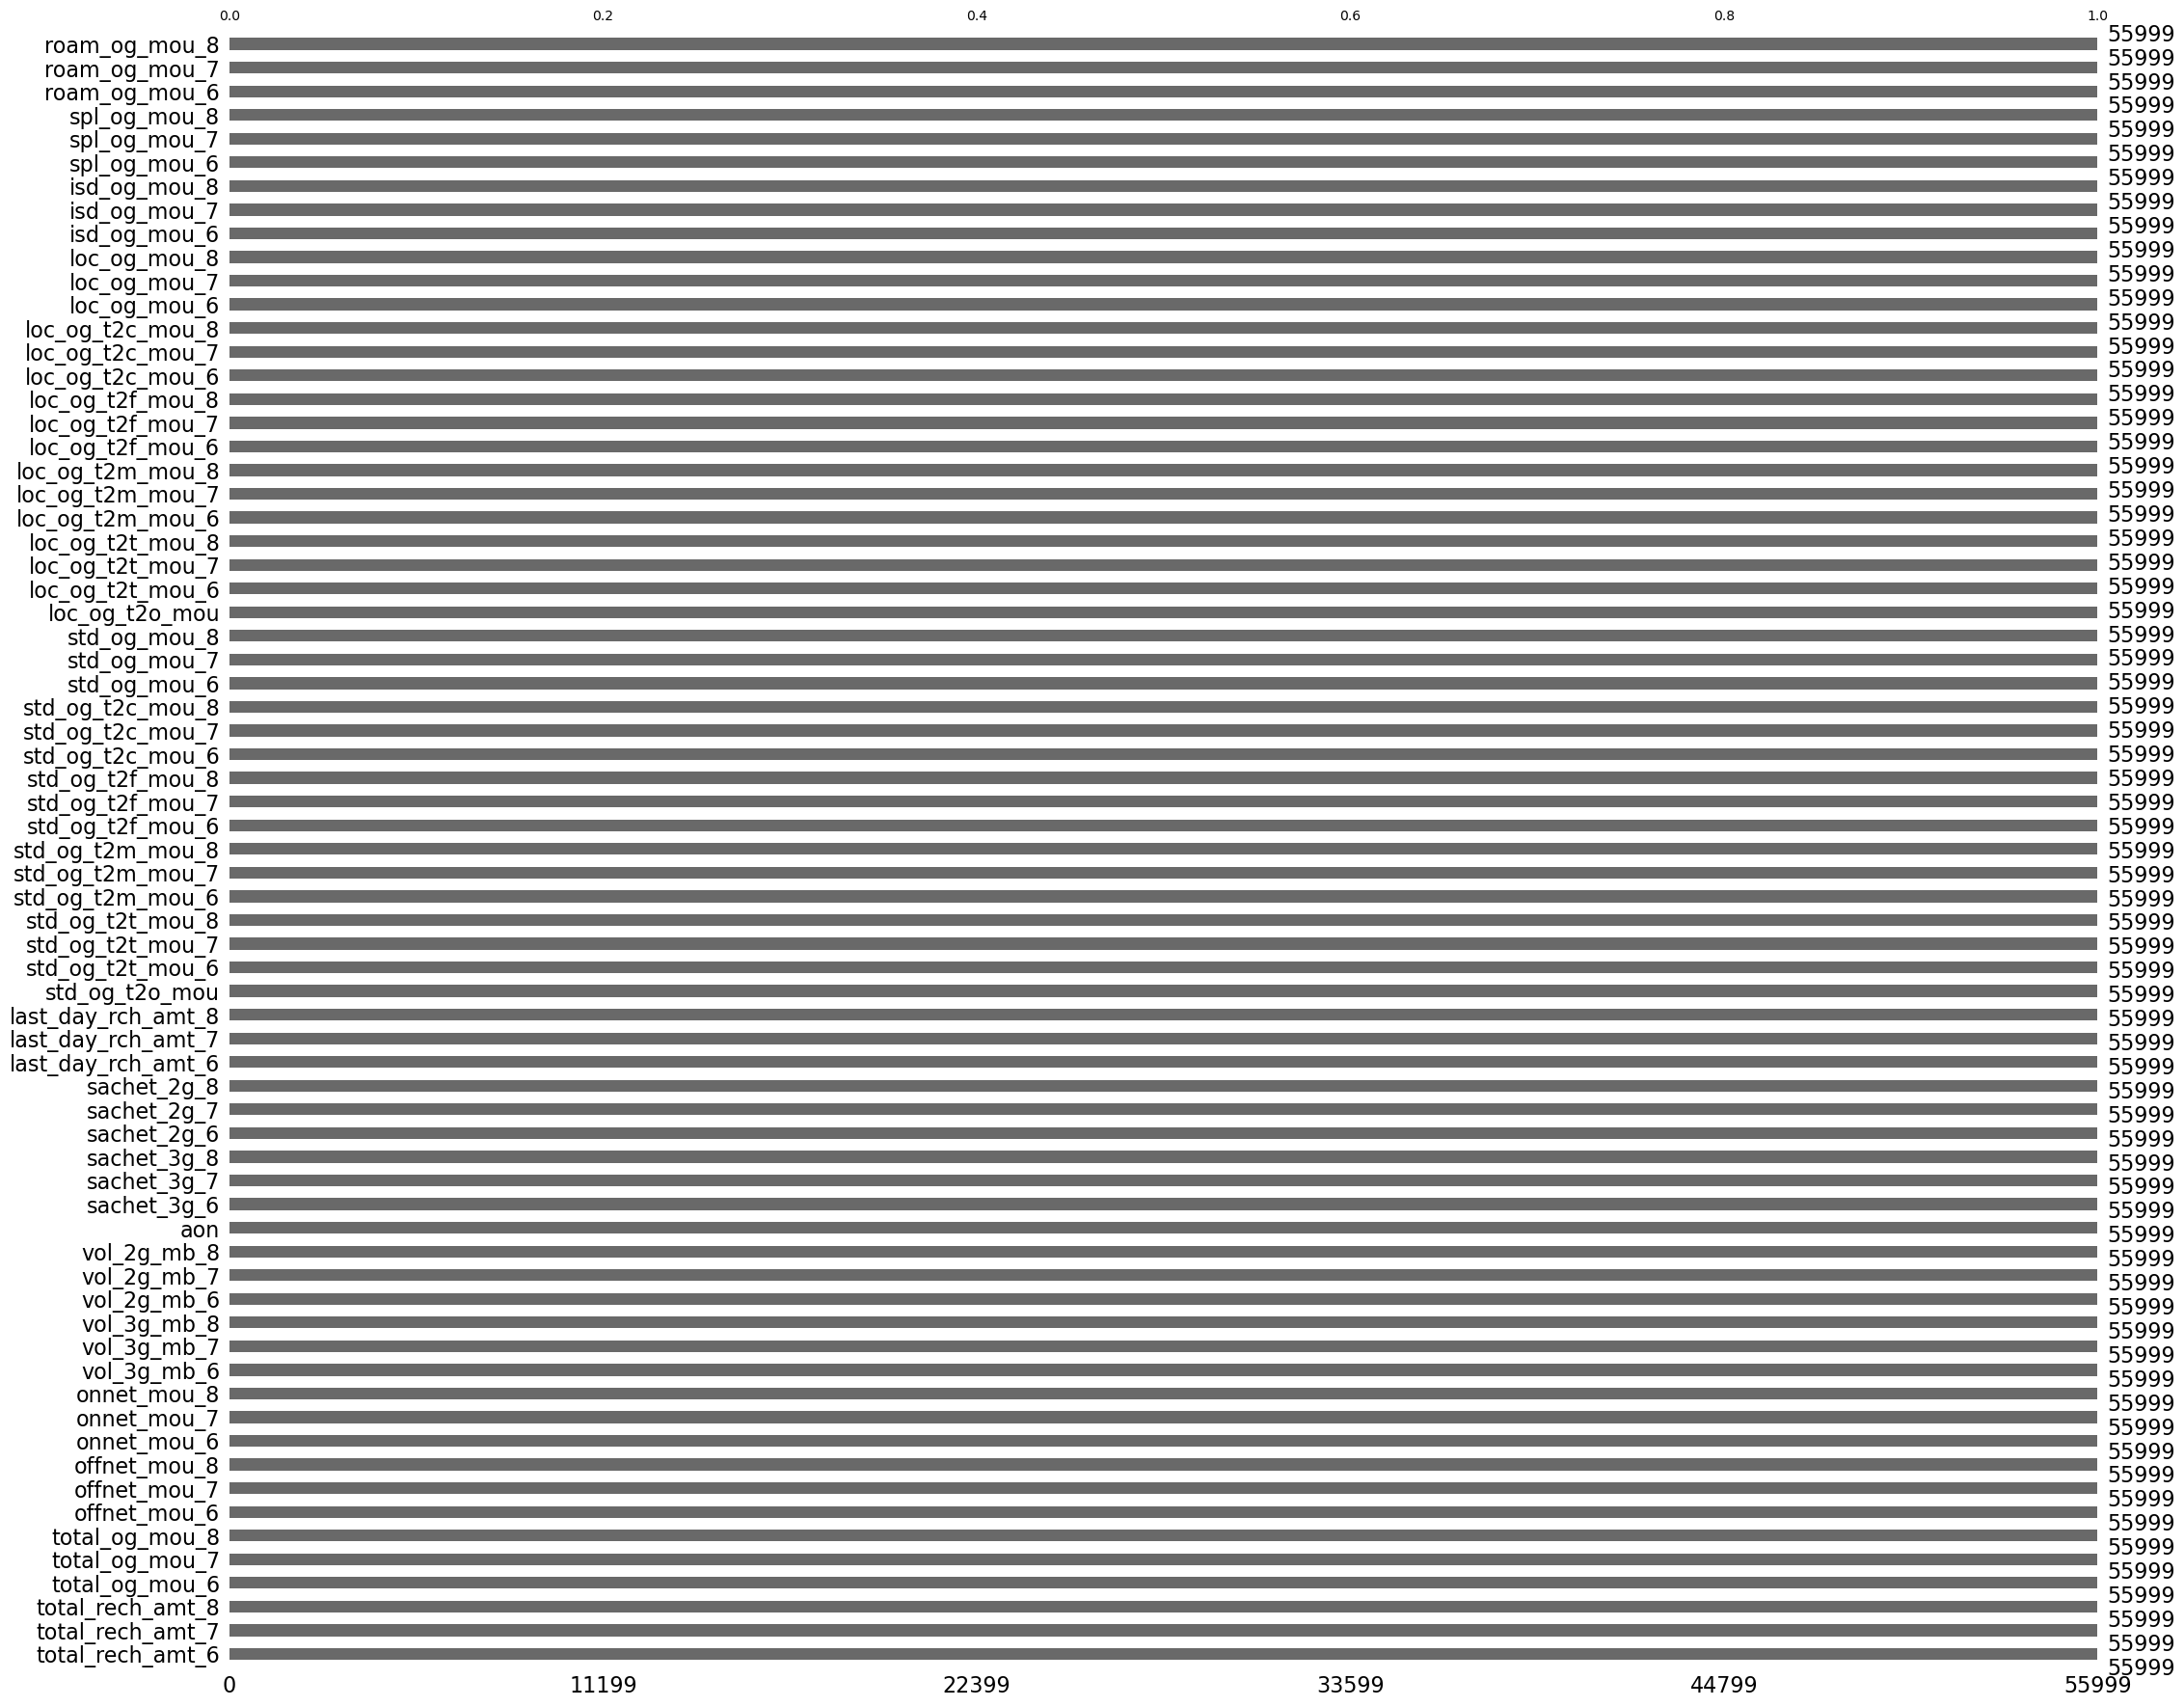

In [147]:
msno.bar(X_train_filtered)

In [148]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,onnet_mou_6,...,loc_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,...,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,329.848283,323.595868,325.125484,308.773414,313.189121,305.498433,192.437812,191.055477,186.848291,128.832638,...,133.337214,0.766999,0.750339,0.746702,3.836396,4.835141,4.817080,13.692956,9.347266,9.346913
std,409.228535,417.676081,432.508734,470.393574,484.772058,476.361949,316.822289,322.976968,315.790063,297.645709,...,239.737408,20.565712,21.745850,20.624677,15.713411,22.811520,17.413067,72.233676,56.399423,62.690858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.000000,100.000000,91.000000,44.880000,43.020000,39.030000,28.960000,26.840000,23.980000,5.480000,...,11.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,230.000000,220.000000,226.000000,145.660000,141.780000,138.660000,90.110000,85.810000,83.540000,30.930000,...,57.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,440.000000,431.000000,437.000000,376.880000,383.735000,373.650000,224.535000,219.115000,217.530000,113.040000,...,156.940000,0.000000,0.000000,0.000000,2.200000,3.340000,3.580000,0.000000,0.000000,0.000000
max,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,11046.740000,8362.360000,7043.980000,7460.210000,7376.710000,...,11039.910000,3229.290000,3868.010000,3629.910000,1023.210000,2372.510000,1075.080000,3775.110000,2812.040000,5337.040000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

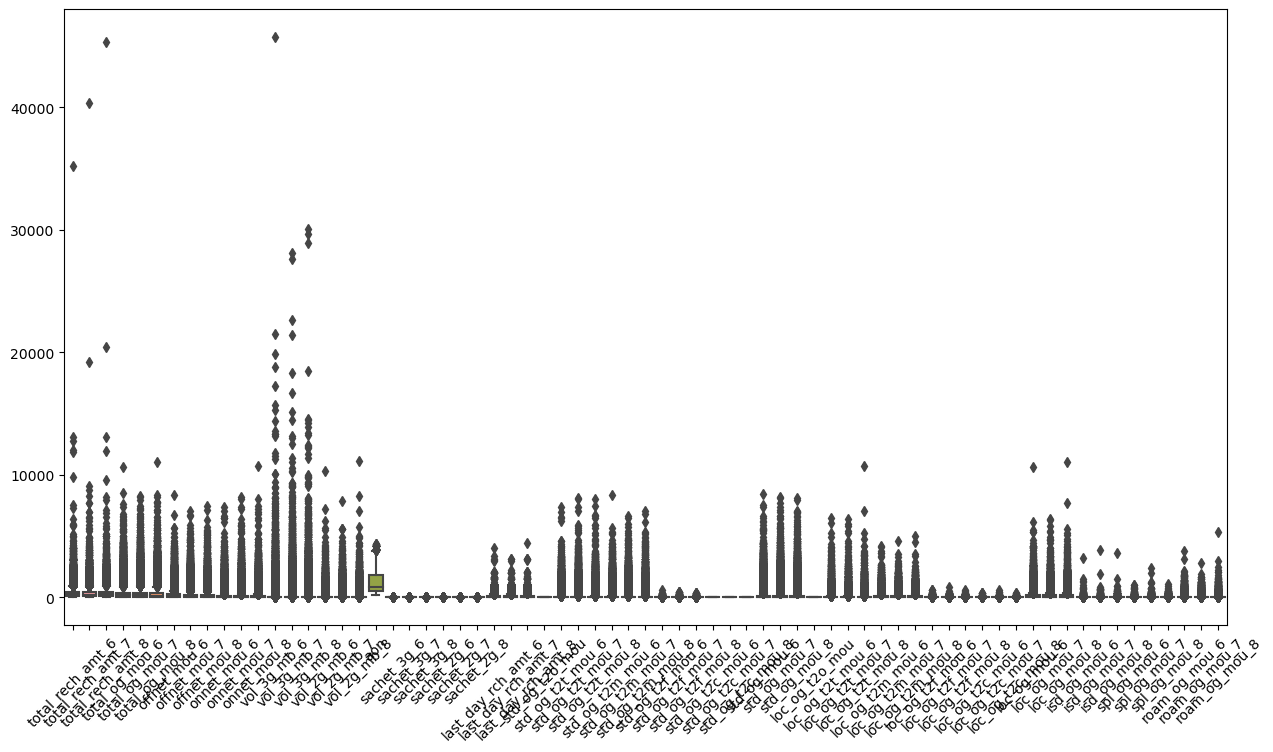

In [149]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [150]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

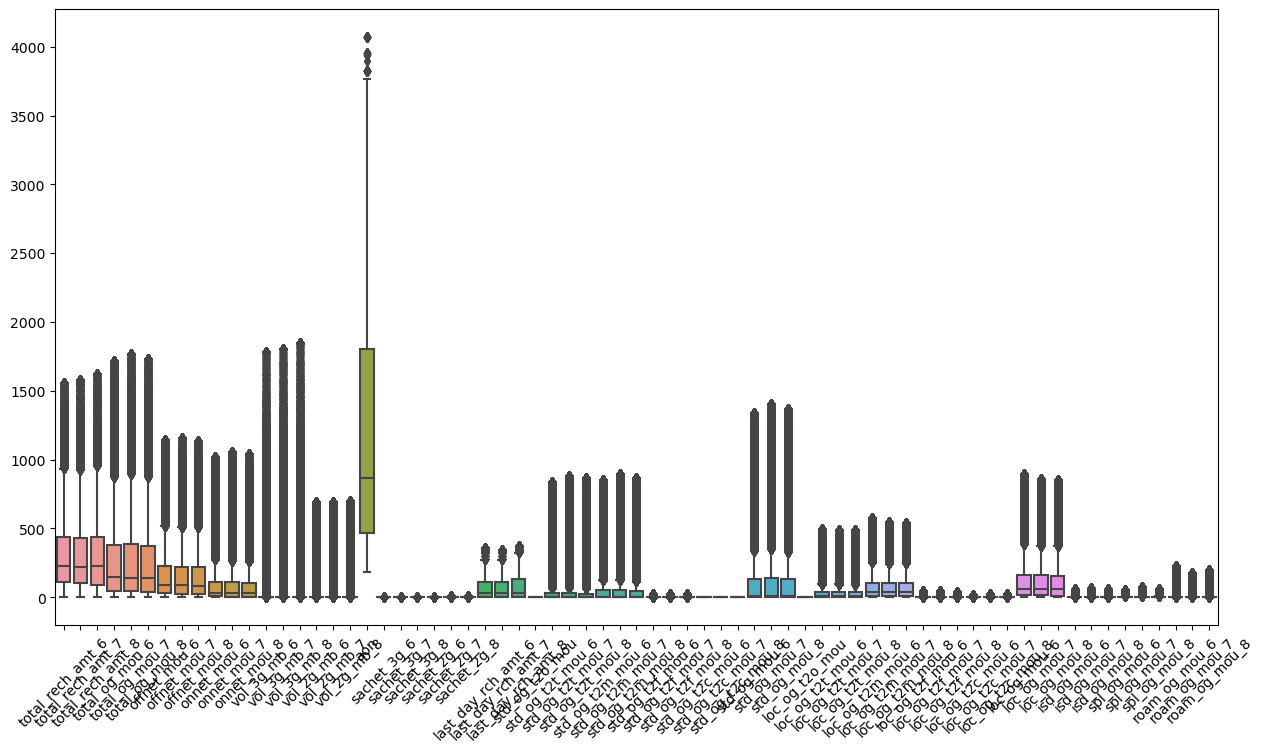

In [151]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [152]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

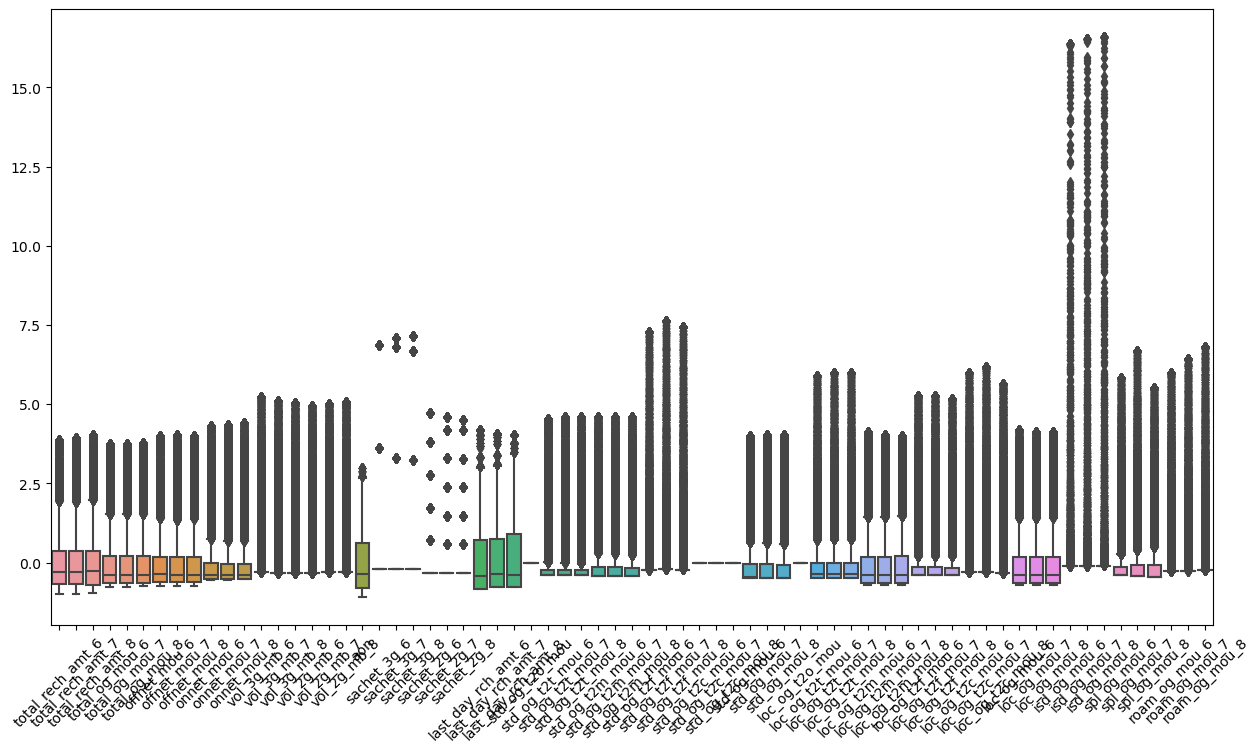

In [153]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

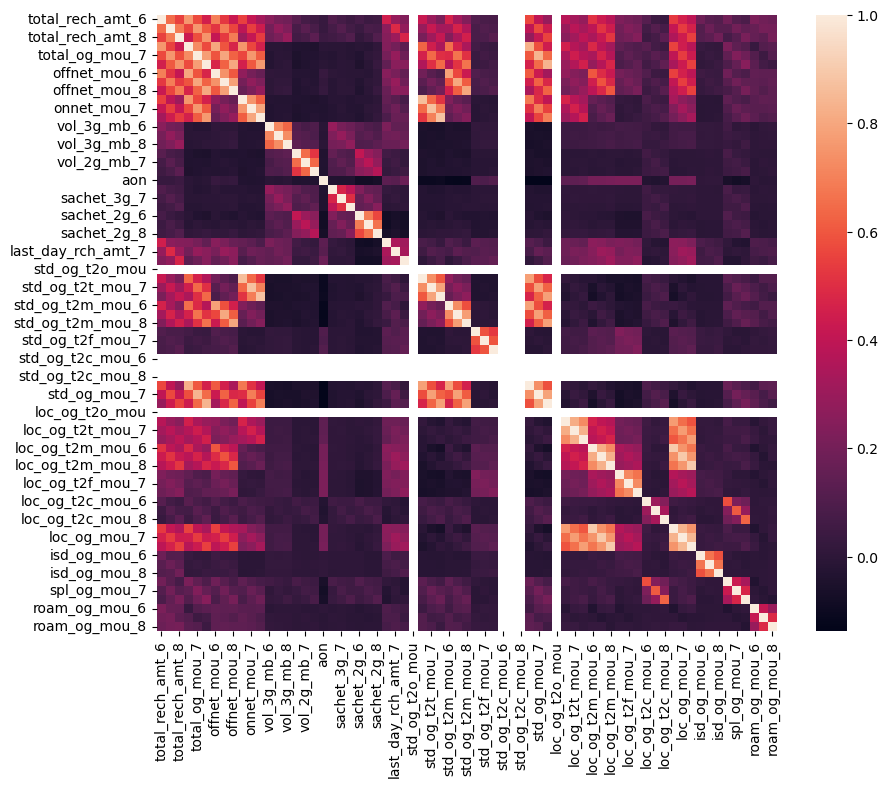

In [154]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

Distribution for the churn probability

<Axes: xlabel='churn_probability', ylabel='Count'>

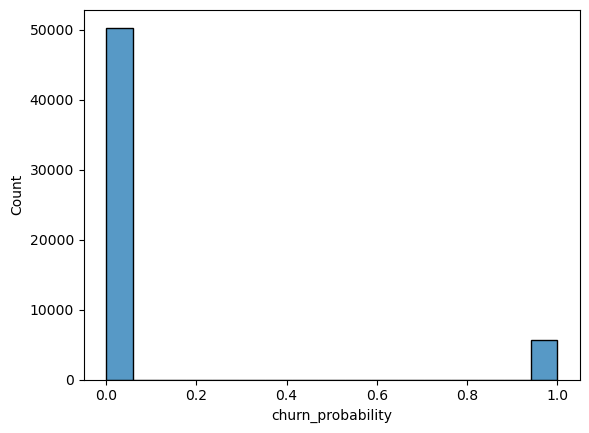

In [155]:
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [156]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [157]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 69 artists>

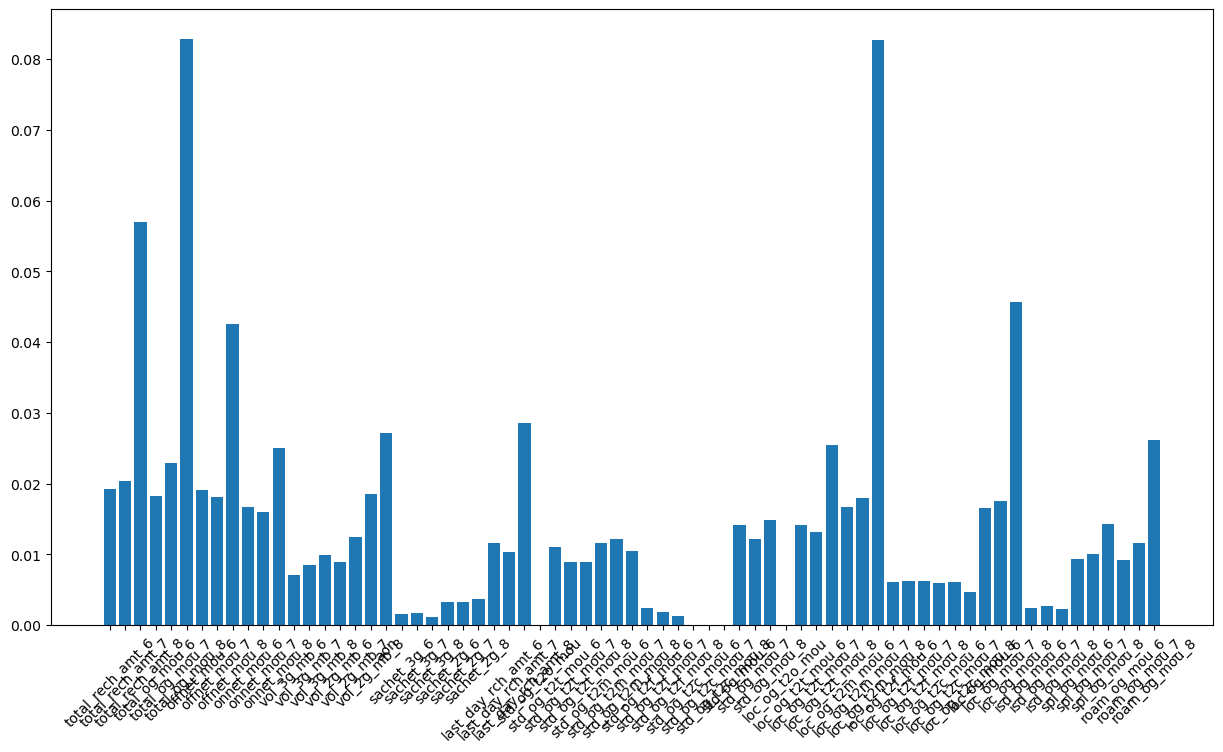

In [158]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

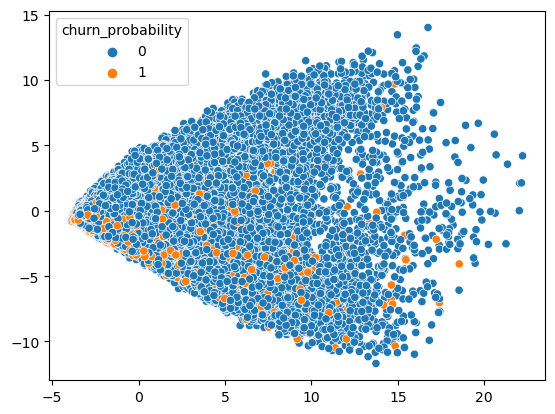

In [159]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

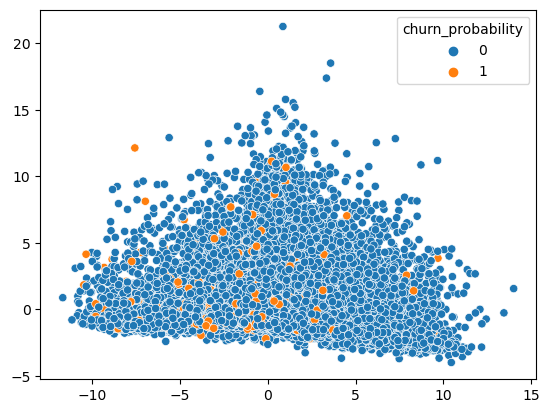

In [160]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [161]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

RandomForestClassifier(n_jobs=-1)

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [162]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [163]:
lr.score(pca_components[:,:2], y_train)

0.8978731763067198

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [164]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [165]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [166]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [167]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8990517687815854


In [168]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9000714285714285


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [169]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[49896,   384],
       [ 5269,   450]])

In [170]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12498,    89],
       [ 1310,   103]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [171]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5364583333333334

In [172]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.07289455060155697

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [173]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [174]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [175]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 69)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [176]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [177]:
output.to_csv('prediction_results.csv',index=False)